In [1]:
# Importar librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configurar device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

Usando device: cuda


In [2]:
# Cargar dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizar a [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, 
                              download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print(f"Dataset cargado: {len(train_dataset)} imágenes")

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]



Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 253kB/s]



Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.50MB/s]



Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Dataset cargado: 60000 imágenes


# cronograma de ruido (noise schedule)

- **Timesteps**: número total de pasos en el proceso de difusión. A mayor cantidad, más gradual es el añadido de ruido.
- **Betas (β)**: valores que indican la cantidad de ruido añadido en cada paso. Se definen de manera lineal desde un valor inicial muy bajo hasta un valor más alto.
- **Alphas (α)**: representan la proporción de señal original que queda después de añadir ruido en cada paso. Se calculan como `1 - β`.
- **Alphas_cumprod (α acumulado)**: producto acumulativo de `α` a lo largo de todos los pasos. Indica cuánta señal total queda tras múltiples pasos de ruido.

## Función del Cronograma de Ruido

1. Se construye un cronograma lineal de betas, que va aumentando gradualmente con cada timestep.
2. A partir de las betas se calculan las alphas, que muestran la fracción de señal restante en cada paso.
3. Se calcula el producto acumulativo de alphas para saber cuánta señal queda después de muchos pasos de difusión.

In [25]:
def get_noise_schedule(timesteps=1000):
    beta_start = 0.0001
    beta_end = 0.02
    
    betas = torch.linspace(beta_start, beta_end, timesteps)
    
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    
    return betas, alphas, alphas_cumprod

timesteps = 1000
betas, alphas, alphas_cumprod = get_noise_schedule(timesteps)

print(f"Cronograma de ruido configurado para {timesteps} pasos")

Cronograma de ruido configurado para 1000 pasos


In [26]:
# SOLUCIÓN RÁPIDA: Volver al cronograma LINEAL que funcionaba bien 🔧
# print("🔄 REVIRTIENDO cambios - usando cronograma lineal original que funcionaba...")

# Usar el cronograma lineal original (que funcionaba)
# timesteps = 1000
# betas, alphas, alphas_cumprod = get_noise_schedule(timesteps)
# 
# print("✅ Cronograma LINEAL restaurado")
# print(f"📊 Usando cronograma que ya sabemos que funciona bien")
# print(f"🎯 Timesteps: {timesteps}")
# print(f"📈 Beta range: {betas.min():.6f} - {betas.max():.6f}")
# 
# # Verificar que las variables están correctamente asignadas
# print(f"\n🧪 Verificación rápida:")
# print(f"   - Betas shape: {betas.shape}")
# print(f"   - Alphas shape: {alphas.shape}") 
# print(f"   - Alphas_cumprod shape: {alphas_cumprod.shape}")
# print(f"   - Alphas_cumprod[100]: {alphas_cumprod[100]:.4f}")
# 
# print("\n✅ Sistema restaurado a configuración funcional anterior")

# Proceso Forward de Difusión

El **proceso forward** añade ruido progresivamente a las imágenes originales para entrenar el modelo de difusión.

## Elementos Clave
- **x₀**: imagen original.  
- **t**: paso o nivel de ruido.  
- **αₜ**: proporción de imagen que queda (de `alphas_cumprod`).  
- **ε**: ruido gaussiano.  
- **xₜ**: imagen ruidosa en el paso t.  

## Fórmula Matemática

En el paso **t**, la imagen con ruido se calcula así:

$$
x_t = \sqrt{\alpha_{t}} \, x_0 \;+\; \sqrt{1 - \alpha_{t}} \, \varepsilon
$$

donde:
- \(x_t\): imagen ruidosa en el paso t.  
- \(x_0\): imagen original.  
- \(\alpha_t\): proporción acumulada de imagen que queda.  
- \(\varepsilon\): ruido gaussiano añadido.  

In [27]:
def forward_diffusion(x0, t, alphas_cumprod):
    batch_size = x0.shape[0]
    
    noise = torch.randn_like(x0)
    
    alpha_cumprod_t = alphas_cumprod[t].view(-1, 1, 1, 1)
    
    x_t = torch.sqrt(alpha_cumprod_t) * x0 + torch.sqrt(1 - alpha_cumprod_t) * noise
    
    return x_t, noise

x_sample, _ = next(iter(train_loader))
x_sample = x_sample[:4]
t_sample = torch.randint(0, timesteps, (4,))

x_noisy, noise_true = forward_diffusion(x_sample, t_sample, alphas_cumprod)
print(f"Proceso forward probado - Forma de entrada: {x_sample.shape}, Forma con ruido: {x_noisy.shape}")

Proceso forward probado - Forma de entrada: torch.Size([4, 1, 28, 28]), Forma con ruido: torch.Size([4, 1, 28, 28])


# Conditional U-Net

## Idea Global
- **Imagen con ruido (x)**: masa de galletas.
- **Paso t (time)**: cuánto hornear.
- **Clase (label)**: forma deseada (estrella, 7…).
- **Modelo**: mezcla todo para predecir el ruido o la imagen limpia.

## Condicionamiento: dos Embeddings
- **Time embedding**: codifica en un vector el paso de ruido \(t\) usando senos/cosenos + MLP.  
- **Class embedding**: asigna un vector único a cada clase (0–9 + null para incondicional).  
- Se concatenan y se procesan en `context_mlp` para un solo **context_emb**.

## Fórmula Conceptual del Forward
En cada capa se combina la info local y global así:

$$
h_{\text{out}} = \text{Conv}(h_{\text{in}}) + W_{\text{proj}} \, \text{context\_emb}
$$

donde:
- \(h_{\text{in}}\): entrada del bloque (mapa de características).
- \(W_{\text{proj}}\): proyección lineal del contexto.
- \(\text{context\_emb}\): vector que representa (tiempo + clase).

En resumen: este Conditional U-Net toma **imagen ruidosa**, **paso de ruido** y **clase**, y produce una predicción coherente con la clase solicitada.


In [28]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128, num_classes=10):
        super(ConditionalUNet, self).__init__()
        
        # tamaño del embedding temporal(time embedding)
        self.time_emb_dim = time_emb_dim
        
        # MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        
        self.num_classes = num_classes + 1
        
        # Crea un embedding para cada clase textual
        self.class_emb = nn.Embedding(self.num_classes, time_emb_dim)
        
        # Fusiona tiempo + clase en un solo vector
        self.context_mlp = nn.Sequential(
            nn.Linear(time_emb_dim * 2, time_emb_dim * 2),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim)
        )
        
        # Encoder(4 etapas del encoder)
        self.enc1 = self._make_layer(in_channels, 64, time_emb_dim)
        self.enc2 = self._make_layer(64, 128, time_emb_dim) 
        self.enc3 = self._make_layer(128, 256, time_emb_dim)
        self.enc4 = self._make_layer(256, 512, time_emb_dim)
        
        # Bottleneck
        self.bottleneck = self._make_layer(512, 1024, time_emb_dim)
        
        # Decoder con skip connections(4 etapas del decoder)
        self.dec1 = self._make_layer(1024 + 512, 512, time_emb_dim)
        self.dec2 = self._make_layer(512 + 256, 256, time_emb_dim) 
        self.dec3 = self._make_layer(256 + 128, 128, time_emb_dim)
        self.dec4 = self._make_layer(128 + 64, 64, time_emb_dim)
        
        # Output layer
        self.final = nn.Conv2d(64, out_channels, 1)
        
        # Pooling y upsampling
        self.pool = nn.MaxPool2d(2) # Reduce la imagen a la mitad
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # Aumenta el tamaño al doble
        
    # Crea un bloque e red
    def _make_layer(self, in_ch, out_ch, time_emb_dim):
        return nn.ModuleDict({
            'conv1': nn.Conv2d(in_ch, out_ch, 3, padding=1),
            'norm1': nn.GroupNorm(8, out_ch),
            'conv2': nn.Conv2d(out_ch, out_ch, 3, padding=1), 
            'norm2': nn.GroupNorm(8, out_ch),
            'time_proj': nn.Linear(time_emb_dim, out_ch), # para inyectar el embedding en cada bloque
            'act': nn.SiLU()
        })
    
    # Aplica el contexto a cada bloque
    def _forward_layer(self, x, context_emb, layer):
        h = layer['act'](layer['norm1'](layer['conv1'](x))) # Procesa la imagen con la primera convolucion
        
        # Inyecta el embedding de contexto
        context_proj = layer['time_proj'](context_emb)
        context_proj = context_proj.unsqueeze(-1).unsqueeze(-1)
        h = h + context_proj
        
        h = layer['act'](layer['norm2'](layer['conv2'](h))) # Se refina la informacion en la segunda convolucion
        
        return h
    
    # COnvierte un timestep en un vector con seno y coseno para capturar posiciciones
    def get_time_embedding(self, timesteps):
        half_dim = self.time_emb_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb
    
    def forward(self, x, t, class_labels=None):
        t_emb = self.get_time_embedding(t.float()) 
        t_emb = self.time_mlp(t_emb)
        
        if class_labels is not None:
            c_emb = self.class_emb(class_labels)
        else:
            null_class = torch.full((x.shape[0],), self.num_classes - 1, device=x.device)
            c_emb = self.class_emb(null_class)
        
        context_emb = torch.cat([t_emb, c_emb], dim=1)
        context_emb = self.context_mlp(context_emb)
        
        e1 = self._forward_layer(x, context_emb, self.enc1)
        e2 = self._forward_layer(self.pool(e1), context_emb, self.enc2) 
        e3 = self._forward_layer(self.pool(e2), context_emb, self.enc3)
        e4 = self._forward_layer(self.pool(e3), context_emb, self.enc4)
        
        b = self._forward_layer(self.pool(e4), context_emb, self.bottleneck)
        
        d1 = self.up(b)
        d1 = nn.functional.interpolate(d1, size=e4.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self._forward_layer(d1, context_emb, self.dec1)
        
        d2 = self.up(d1)
        d2 = nn.functional.interpolate(d2, size=e3.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self._forward_layer(d2, context_emb, self.dec2)
        
        d3 = self.up(d2)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self._forward_layer(d3, context_emb, self.dec3)
        
        d4 = self.up(d3)
        d4 = torch.cat([d4, e1], dim=1) 
        d4 = self._forward_layer(d4, context_emb, self.dec4)
        
        out = self.final(d4)
        
        return out

conditional_model = ConditionalUNet().to(device)
total_params = sum(p.numel() for p in conditional_model.parameters())
print(f"Modelo CONDICIONAL creado con {total_params:,} parámetros")

print("Copiando pesos del modelo incondicional (Transfer Learning)...")
try:
    old_state_dict = model.state_dict()
    new_state_dict = conditional_model.state_dict()
    
    copied_weights = 0
    for key in old_state_dict:
        if key in new_state_dict and old_state_dict[key].shape == new_state_dict[key].shape:
            new_state_dict[key] = old_state_dict[key].clone()
            copied_weights += 1
    
    conditional_model.load_state_dict(new_state_dict)
    print(f"Transfer Learning exitoso - {copied_weights} capas copiadas")
    
    model = conditional_model
    
except Exception as e:
    print(f"Transfer learning parcial - continuando con inicialización aleatoria")
    model = conditional_model

class_names = {
    0: "cero", 1: "uno", 2: "dos", 3: "tres", 4: "cuatro",
    5: "cinco", 6: "seis", 7: "siete", 8: "ocho", 9: "nueve"
}

# print("\nProbando el modelo CONDICIONAL...")
# with torch.no_grad():
#     test_x = torch.randn(3, 1, 28, 28).to(device)
#     test_t = torch.randint(0, 1000, (3,)).to(device)
#     test_classes = torch.tensor([0, 5, 9]).to(device)
#     
#     test_output_cond = model(test_x, test_t, test_classes)
#     print(f"Test CONDICIONAL exitoso - Input: {test_x.shape}, Output: {test_output_cond.shape}")
#     print(f"Condicionado a clases: {test_classes.cpu().tolist()}")
#     
#     test_output_uncond = model(test_x, test_t, None)
#     print(f"Test INCONDICIONAL exitoso - Output: {test_output_uncond.shape}")
#     print(f"Diferencia entre condicional e incondicional: {(test_output_cond - test_output_uncond).abs().mean().item():.4f}")
# 
# print("\nModelo condicional listo para entrenar!")
# print("Ahora puedes generar dígitos específicos: 'genera un 7', 'genera un 0', etc.")

Modelo CONDICIONAL creado con 32,001,153 parámetros
Copiando pesos del modelo incondicional (Transfer Learning)...
Transfer Learning exitoso - 101 capas copiadas


In [29]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def conditional_train_step(model, x0, labels, t, alphas_cumprod, optimizer, cfg_prob=0.1):
    optimizer.zero_grad()
    
    # Añade ruido a la imagen original
    x_t, noise_true = forward_diffusion(x0, t, alphas_cumprod)
    
    x_t = x_t.to(device)
    t = t.to(device)
    labels = labels.to(device)
    noise_true = noise_true.to(device)
    
    # Condicional o Incondicional
    if torch.rand(1).item() < cfg_prob:
        noise_pred = model(x_t, t, None)
    else:
        noise_pred = model(x_t, t, labels)
    
    loss = criterion(noise_pred, noise_true)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [ ]:
epochs = 15
losses = []

for epoch in range(epochs):
    epoch_losses = []
    
    # Forward, Backward y actualización de pesos por cada batch
    for batch_idx, (x0, labels) in enumerate(tqdm(train_loader, desc=f'Época {epoch+1}/{epochs}')):
        batch_size = x0.shape[0]
        t = torch.randint(0, timesteps, (batch_size,))
        loss = conditional_train_step(model, x0, labels, t, alphas_cumprod, optimizer)
        epoch_losses.append(loss)
        
        if batch_idx % 100 == 0:
            print(f'  Batch {batch_idx}, Loss: {loss:.4f}')
    
    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    print(f'Época {epoch+1} completada - Loss promedio: {avg_loss:.4f}')
    
    # Para ver si el modelo esta aprendiendo
    if (epoch + 1) % 5 == 0:
        print(f"Probando generación condicional en época {epoch+1}...")
        with torch.no_grad():
            test_classes = torch.tensor([0, 1, 2, 3]).to(device)
            test_x = torch.randn(4, 1, 28, 28).to(device)
            test_t = torch.randint(100, 200, (4,)).to(device)
            
            cond_output = model(test_x, test_t, test_classes)
            uncond_output = model(test_x, test_t, None)
            
            diff = (cond_output - uncond_output).abs().mean().item()
            print(f"   Diferencia condicional vs incondicional: {diff:.4f}")
            
            if diff > 0.001:
                print("   Modelo está aprendiendo condicionamiento!")
            else:
                print("   Condicionamiento aún débil, necesita más entrenamiento")

🚀 Iniciando entrenamiento CONDICIONAL...
📝 El modelo aprenderá a generar dígitos específicos según las etiquetas


Época 1/15:   0%|          | 2/469 [00:00<02:17,  3.40it/s]

  Batch 0, Loss: 0.2046


Época 1/15:  22%|██▏       | 102/469 [00:15<00:56,  6.48it/s]

  Batch 100, Loss: 0.0278


Época 1/15:  43%|████▎     | 202/469 [00:31<00:40,  6.59it/s]

  Batch 200, Loss: 0.0246


Época 1/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.57it/s]

  Batch 300, Loss: 0.0289


Época 1/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.57it/s]

  Batch 400, Loss: 0.0241


Época 1/15: 100%|██████████| 469/469 [01:11<00:00,  6.53it/s]


Época 1 completada - Loss promedio: 0.0295


Época 2/15:   0%|          | 1/469 [00:00<01:10,  6.60it/s]

  Batch 0, Loss: 0.0316


Época 2/15:  22%|██▏       | 102/469 [00:15<00:55,  6.59it/s]

  Batch 100, Loss: 0.0270


Época 2/15:  43%|████▎     | 202/469 [00:30<00:40,  6.53it/s]

  Batch 200, Loss: 0.0192


Época 2/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.65it/s]

  Batch 300, Loss: 0.0231


Época 2/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.38it/s]

  Batch 400, Loss: 0.0272


Época 2/15: 100%|██████████| 469/469 [01:11<00:00,  6.53it/s]


Época 2 completada - Loss promedio: 0.0246


Época 3/15:   0%|          | 1/469 [00:00<01:13,  6.40it/s]

  Batch 0, Loss: 0.0228


Época 3/15:  22%|██▏       | 102/469 [00:15<00:55,  6.62it/s]

  Batch 100, Loss: 0.0191


Época 3/15:  43%|████▎     | 202/469 [00:30<00:40,  6.65it/s]

  Batch 200, Loss: 0.0194


Época 3/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.46it/s]

  Batch 300, Loss: 0.0192


Época 3/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.52it/s]

  Batch 400, Loss: 0.0291


Época 3/15: 100%|██████████| 469/469 [01:11<00:00,  6.54it/s]


Época 3 completada - Loss promedio: 0.0237


Época 4/15:   0%|          | 1/469 [00:00<01:11,  6.53it/s]

  Batch 0, Loss: 0.0234


Época 4/15:  22%|██▏       | 102/469 [00:15<00:55,  6.58it/s]

  Batch 100, Loss: 0.0243


Época 4/15:  43%|████▎     | 202/469 [00:30<00:41,  6.51it/s]

  Batch 200, Loss: 0.0233


Época 4/15:  64%|██████▍   | 302/469 [00:45<00:25,  6.58it/s]

  Batch 300, Loss: 0.0204


Época 4/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.64it/s]

  Batch 400, Loss: 0.0221


Época 4/15: 100%|██████████| 469/469 [01:11<00:00,  6.57it/s]


Época 4 completada - Loss promedio: 0.0237


Época 5/15:   0%|          | 1/469 [00:00<01:11,  6.51it/s]

  Batch 0, Loss: 0.0216


Época 5/15:  22%|██▏       | 102/469 [00:15<00:55,  6.59it/s]

  Batch 100, Loss: 0.0247


Época 5/15:  43%|████▎     | 202/469 [00:30<00:41,  6.46it/s]

  Batch 200, Loss: 0.0270


Época 5/15:  64%|██████▍   | 302/469 [00:45<00:25,  6.61it/s]

  Batch 300, Loss: 0.0185


Época 5/15:  86%|████████▌ | 402/469 [01:00<00:10,  6.59it/s]

  Batch 400, Loss: 0.0237


Época 5/15: 100%|██████████| 469/469 [01:11<00:00,  6.59it/s]


Época 5 completada - Loss promedio: 0.0235
🧪 Probando generación condicional en época 5...
   📊 Diferencia condicional vs incondicional: 0.0313
   ✅ Modelo está aprendiendo condicionamiento!


Época 6/15:   0%|          | 1/469 [00:00<01:14,  6.28it/s]

  Batch 0, Loss: 0.0250


Época 6/15:  22%|██▏       | 102/469 [00:15<00:56,  6.55it/s]

  Batch 100, Loss: 0.0228


Época 6/15:  43%|████▎     | 202/469 [00:30<00:40,  6.53it/s]

  Batch 200, Loss: 0.0257


Época 6/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.47it/s]

  Batch 300, Loss: 0.0240


Época 6/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.45it/s]

  Batch 400, Loss: 0.0196


Época 6/15: 100%|██████████| 469/469 [01:11<00:00,  6.54it/s]


Época 6 completada - Loss promedio: 0.0228


Época 7/15:   0%|          | 1/469 [00:00<01:11,  6.53it/s]

  Batch 0, Loss: 0.0237


Época 7/15:  22%|██▏       | 102/469 [00:15<00:56,  6.55it/s]

  Batch 100, Loss: 0.0200


Época 7/15:  43%|████▎     | 202/469 [00:30<00:41,  6.47it/s]

  Batch 200, Loss: 0.0221


Época 7/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.55it/s]

  Batch 300, Loss: 0.0181


Época 7/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.60it/s]

  Batch 400, Loss: 0.0208


Época 7/15: 100%|██████████| 469/469 [01:11<00:00,  6.55it/s]


Época 7 completada - Loss promedio: 0.0232


Época 8/15:   0%|          | 1/469 [00:00<01:10,  6.63it/s]

  Batch 0, Loss: 0.0226


Época 8/15:  22%|██▏       | 102/469 [00:15<00:56,  6.54it/s]

  Batch 100, Loss: 0.0209


Época 8/15:  43%|████▎     | 202/469 [00:30<00:40,  6.64it/s]

  Batch 200, Loss: 0.0258


Época 8/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.57it/s]

  Batch 300, Loss: 0.0231


Época 8/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.61it/s]

  Batch 400, Loss: 0.0211


Época 8/15: 100%|██████████| 469/469 [01:11<00:00,  6.56it/s]


Época 8 completada - Loss promedio: 0.0229


Época 9/15:   0%|          | 1/469 [00:00<01:11,  6.56it/s]

  Batch 0, Loss: 0.0253


Época 9/15:  22%|██▏       | 102/469 [00:15<00:54,  6.68it/s]

  Batch 100, Loss: 0.0241


Época 9/15:  43%|████▎     | 202/469 [00:30<00:41,  6.50it/s]

  Batch 200, Loss: 0.0234


Época 9/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.53it/s]

  Batch 300, Loss: 0.0205


Época 9/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.60it/s]

  Batch 400, Loss: 0.0259


Época 9/15: 100%|██████████| 469/469 [01:11<00:00,  6.55it/s]


Época 9 completada - Loss promedio: 0.0227


Época 10/15:   0%|          | 1/469 [00:00<01:15,  6.22it/s]

  Batch 0, Loss: 0.0231


Época 10/15:  22%|██▏       | 102/469 [00:15<00:55,  6.61it/s]

  Batch 100, Loss: 0.0253


Época 10/15:  43%|████▎     | 202/469 [00:31<00:40,  6.56it/s]

  Batch 200, Loss: 0.0262


Época 10/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.59it/s]

  Batch 300, Loss: 0.0247


Época 10/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.50it/s]

  Batch 400, Loss: 0.0192


Época 10/15: 100%|██████████| 469/469 [01:11<00:00,  6.51it/s]


Época 10 completada - Loss promedio: 0.0227
🧪 Probando generación condicional en época 10...
   📊 Diferencia condicional vs incondicional: 0.0278
   ✅ Modelo está aprendiendo condicionamiento!


Época 11/15:   0%|          | 1/469 [00:00<01:14,  6.26it/s]

  Batch 0, Loss: 0.0200


Época 11/15:  22%|██▏       | 102/469 [00:15<00:56,  6.53it/s]

  Batch 100, Loss: 0.0281


Época 11/15:  43%|████▎     | 202/469 [00:30<00:41,  6.51it/s]

  Batch 200, Loss: 0.0231


Época 11/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.56it/s]

  Batch 300, Loss: 0.0187


Época 11/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.58it/s]

  Batch 400, Loss: 0.0229


Época 11/15: 100%|██████████| 469/469 [01:11<00:00,  6.54it/s]


Época 11 completada - Loss promedio: 0.0224


Época 12/15:   0%|          | 1/469 [00:00<01:10,  6.62it/s]

  Batch 0, Loss: 0.0236


Época 12/15:  22%|██▏       | 102/469 [00:15<00:56,  6.51it/s]

  Batch 100, Loss: 0.0206


Época 12/15:  43%|████▎     | 202/469 [00:30<00:40,  6.56it/s]

  Batch 200, Loss: 0.0254


Época 12/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.50it/s]

  Batch 300, Loss: 0.0719


Época 12/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.62it/s]

  Batch 400, Loss: 0.0310


Época 12/15: 100%|██████████| 469/469 [01:11<00:00,  6.55it/s]


Época 12 completada - Loss promedio: 0.0277


Época 13/15:   0%|          | 1/469 [00:00<01:10,  6.66it/s]

  Batch 0, Loss: 0.0237


Época 13/15:  22%|██▏       | 102/469 [00:15<00:56,  6.55it/s]

  Batch 100, Loss: 0.0218


Época 13/15:  43%|████▎     | 202/469 [00:30<00:41,  6.49it/s]

  Batch 200, Loss: 0.0247


Época 13/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.54it/s]

  Batch 300, Loss: 0.0207


Época 13/15:  86%|████████▌ | 402/469 [01:01<00:10,  6.56it/s]

  Batch 400, Loss: 0.0270


Época 13/15: 100%|██████████| 469/469 [01:11<00:00,  6.53it/s]


Época 13 completada - Loss promedio: 0.0234


Época 14/15:   0%|          | 1/469 [00:00<01:15,  6.21it/s]

  Batch 0, Loss: 0.0219


Época 14/15:  22%|██▏       | 102/469 [00:15<00:57,  6.41it/s]

  Batch 100, Loss: 0.0241


Época 14/15:  43%|████▎     | 202/469 [00:31<00:41,  6.50it/s]

  Batch 200, Loss: 0.0216


Época 14/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.43it/s]

  Batch 300, Loss: 0.0217


Época 14/15:  86%|████████▌ | 402/469 [01:02<00:10,  6.39it/s]

  Batch 400, Loss: 0.0240


Época 14/15: 100%|██████████| 469/469 [01:12<00:00,  6.45it/s]


Época 14 completada - Loss promedio: 0.0226


Época 15/15:   0%|          | 1/469 [00:00<01:12,  6.46it/s]

  Batch 0, Loss: 0.0247


Época 15/15:  22%|██▏       | 102/469 [00:15<00:56,  6.51it/s]

  Batch 100, Loss: 0.0198


Época 15/15:  43%|████▎     | 202/469 [00:31<00:40,  6.59it/s]

  Batch 200, Loss: 0.0200


Época 15/15:  64%|██████▍   | 302/469 [00:46<00:25,  6.55it/s]

  Batch 300, Loss: 0.0190


Época 15/15:  86%|████████▌ | 402/469 [01:02<00:10,  6.40it/s]

  Batch 400, Loss: 0.0218


Época 15/15: 100%|██████████| 469/469 [01:12<00:00,  6.44it/s]

Época 15 completada - Loss promedio: 0.0221
🧪 Probando generación condicional en época 15...
   📊 Diferencia condicional vs incondicional: 0.0321
   ✅ Modelo está aprendiendo condicionamiento!
🎉 Entrenamiento CONDICIONAL completado!
🎯 Ahora puedes generar dígitos específicos con prompts textuales


In [ ]:
@torch.no_grad()
def conditional_sample_images(model, prompts, n_samples=4, img_size=(1, 28, 28), guidance_scale=7.5, show_process=True):
    
    model.eval()
    
    # Empezar con ruido puro
    x_t = torch.randn(n_samples, *img_size).to(device)
    
    # Convertir prompts a tensor
    if prompts is not None:
        class_labels = torch.tensor(prompts).to(device)
    else:
        class_labels = None
    
    process_steps = []
    if show_process:
        save_at = [999, 750, 500, 250, 0]
        
    # Proceso de denoising (reverse diffusion)
    for i, t in enumerate(tqdm(range(timesteps-1, -1, -1), desc="Generando con condicionamiento")):
        t_tensor = torch.full((n_samples,), t).to(device)
        
        if class_labels is not None and guidance_scale > 1.0:
            noise_pred_cond = model(x_t, t_tensor, class_labels)
            
            noise_pred_uncond = model(x_t, t_tensor, None)
            
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
        else:
            noise_pred = model(x_t, t_tensor, class_labels)
        
        alpha_t = alphas[t].to(device)
        beta_t = betas[t].to(device)
        
        # Fórmula de denoising
        x_t = (x_t - beta_t / torch.sqrt(1 - alphas_cumprod[t].to(device)) * noise_pred) / torch.sqrt(alpha_t)
        
        # Añadir ruido solo si no estamos en el último paso
        if t > 0:
            z = torch.randn_like(x_t)
            x_t += torch.sqrt(beta_t) * z
        
        if show_process and t in save_at:
            process_steps.append((t, x_t.clone().cpu()))
    
    if show_process:
        return x_t, process_steps
    else:
        return x_t

def plot_denoising_process(process_steps, prompts=None, title="Proceso de Denoising"):
    n_steps = len(process_steps)
    n_samples = process_steps[0][1].shape[0]
    
    fig, axes = plt.subplots(n_samples, n_steps, figsize=(n_steps * 3, n_samples * 3))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for sample_idx in range(n_samples):
        for step_idx, (timestep, images) in enumerate(process_steps):
            # Obtener imagen de este sample y paso
            img = images[sample_idx].squeeze()
            img_np = (img + 1) / 2  # De [-1, 1] a [0, 1]
            img_np = np.clip(img_np, 0, 1)
            
            # Mostrar imagen
            axes[sample_idx, step_idx].imshow(img_np, cmap='gray')
            axes[sample_idx, step_idx].axis('off')
            
            # Título de la columna (timestep)
            if sample_idx == 0:
                if timestep == 0:
                    axes[sample_idx, step_idx].set_title(f"Final\n(t={timestep})", fontsize=10)
                else:
                    axes[sample_idx, step_idx].set_title(f"t={timestep}", fontsize=10)
            
            # Título de la fila (prompt)
            if step_idx == 0 and prompts is not None:
                prompt_text = f"'{class_names[prompts[sample_idx]]}'" if prompts[sample_idx] in class_names else f"Clase {prompts[sample_idx]}"
                axes[sample_idx, step_idx].set_ylabel(prompt_text, fontsize=12, rotation=0, ha='right', va='center')
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

🎨 Funciones de generación CONDICIONAL configuradas
📸 Ahora verás el proceso de denoising en 5 pasos
🎯 Puedes controlar qué dígitos generar


🎯 EXPERIMENTO 1: Generación Condicional
Generando dígitos específicos: 0, 3, 7, 9


🎨 Generando con condicionamiento: 100%|██████████| 1000/1000 [00:12<00:00, 78.87it/s]



📸 Proceso de Denoising (5 pasos):


C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_13892\3150446652.py:104: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\VICTUS hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\VICTUS hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


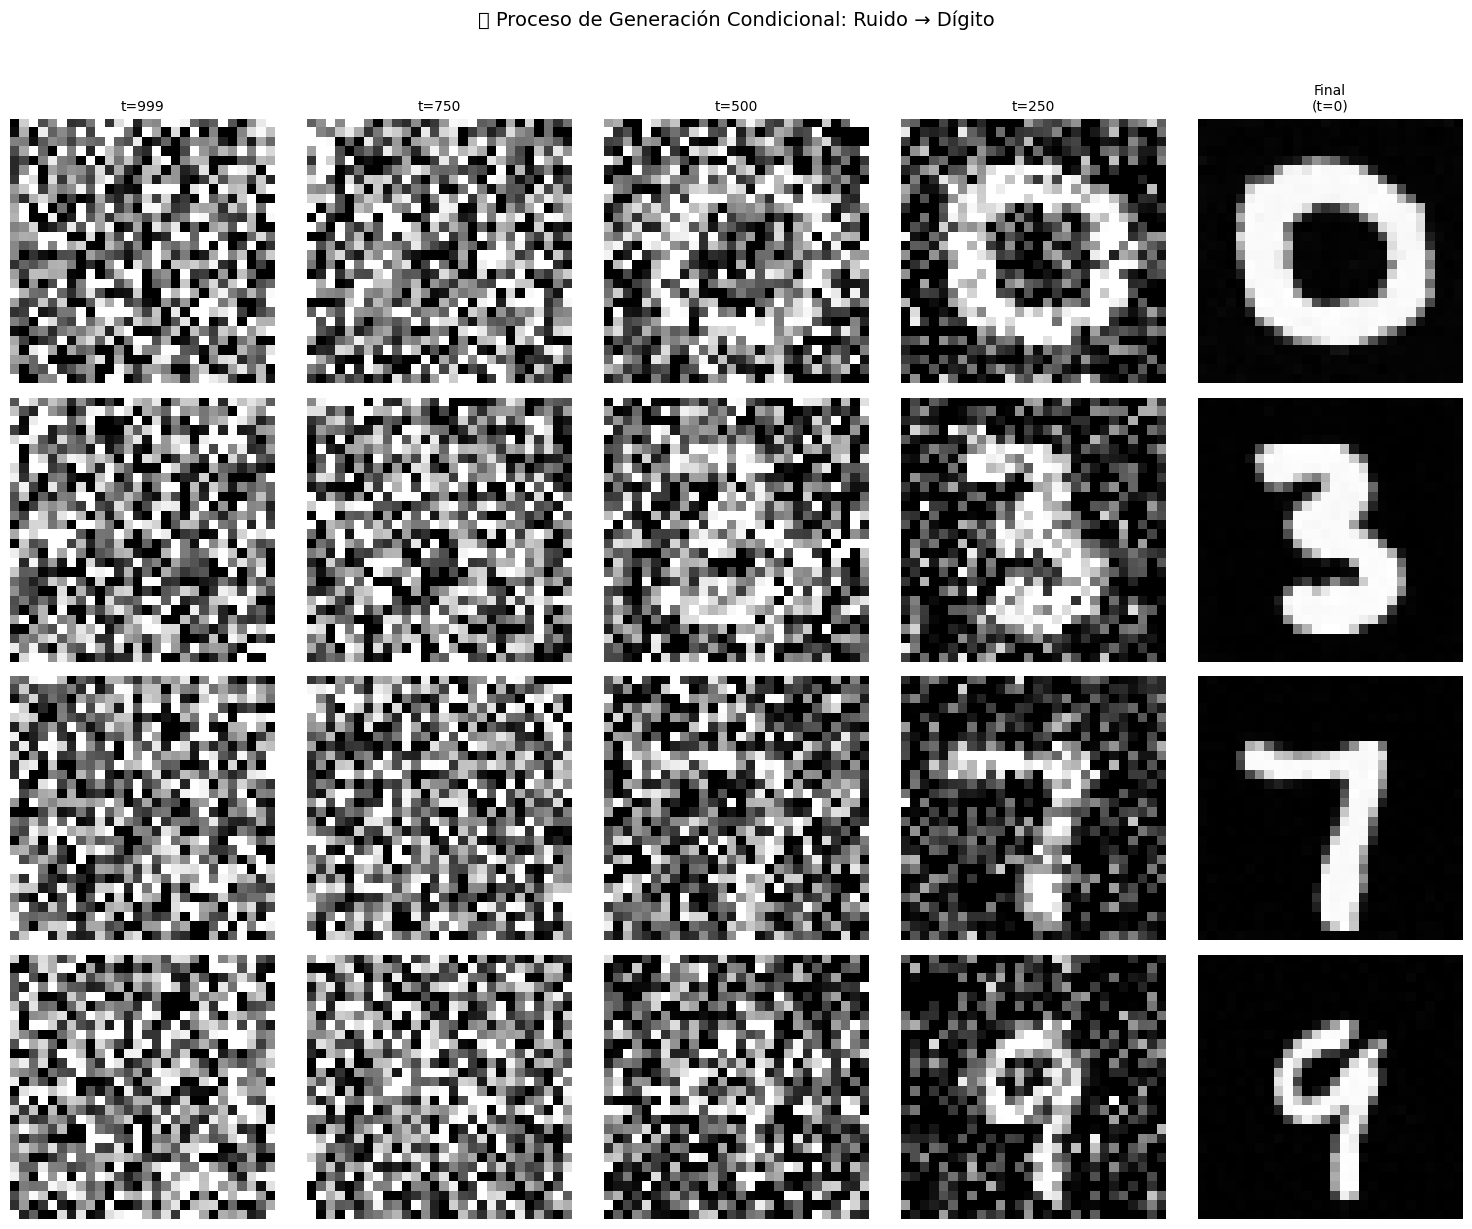

✨ Resultados Finales:


C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_13892\1023538268.py:23: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()


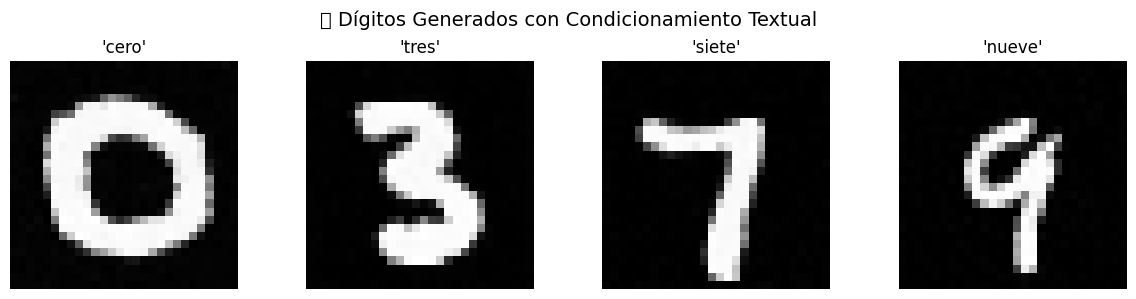


🎲 EXPERIMENTO 2: Condicional vs Incondicional
Comparando generación con y sin condicionamiento...


🎨 Generando con condicionamiento: 100%|██████████| 1000/1000 [00:07<00:00, 137.93it/s]
C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_13892\1023538268.py:23: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  plt.tight_layout()

C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_13892\1023538268.py:23: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  plt.tight_layout()
C:\Users\VICTUS hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\VICTUS hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


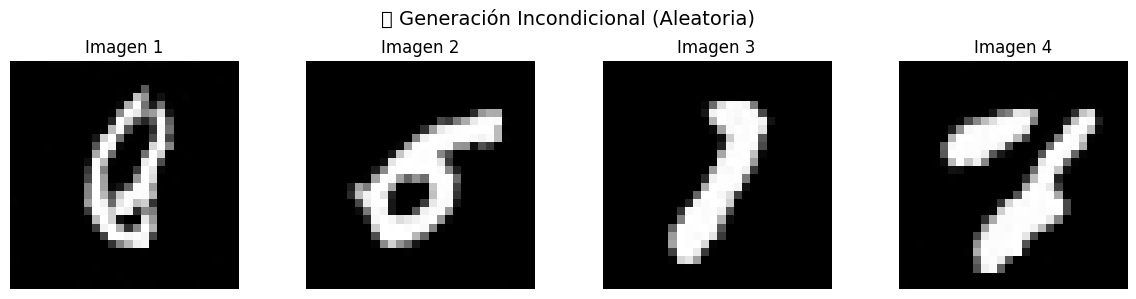


🔧 EXPERIMENTO 3: Diferentes niveles de Guidance
Probando diferentes fuerzas de condicionamiento...


🎨 Generando con condicionamiento: 100%|██████████| 1000/1000 [00:10<00:00, 92.46it/s]
C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_13892\1023538268.py:82: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  plt.tight_layout()

C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_13892\1023538268.py:82: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  plt.tight_layout()
C:\Users\VICTUS hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\VICTUS hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


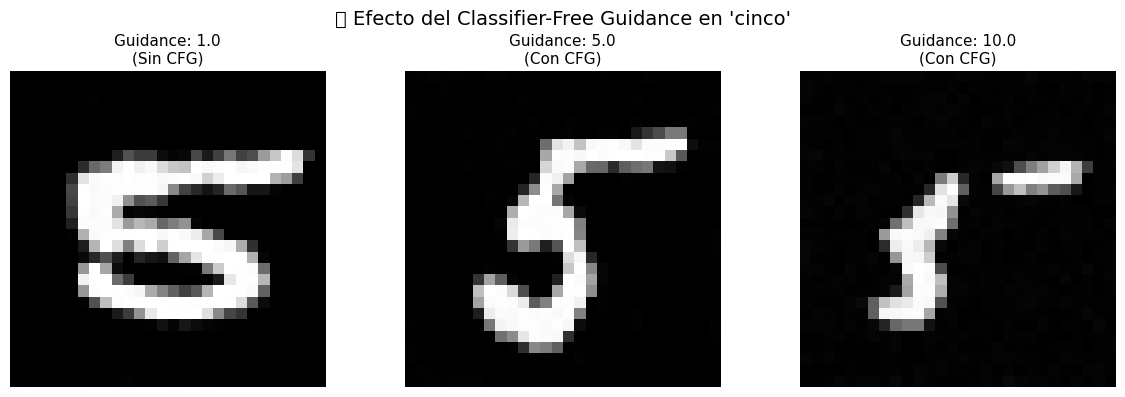

C:\Users\VICTUS hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


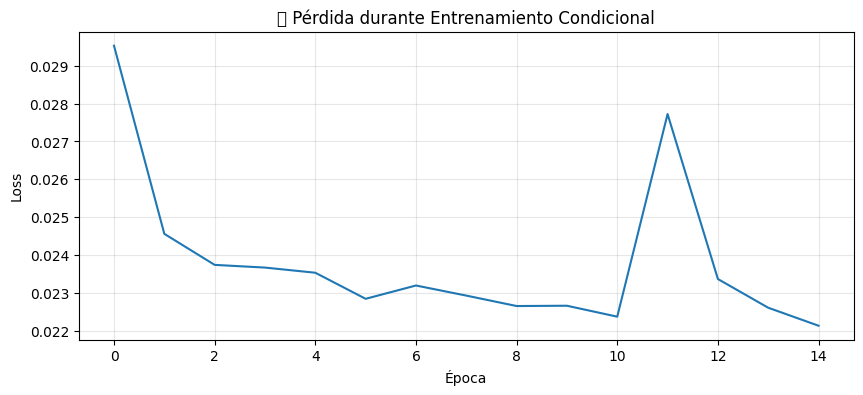

🎉 ¡Generación condicional completa!
💡 Ahora puedes controlar exactamente qué dígitos generar
🎨 El proceso de denoising muestra cómo el ruido se convierte en dígitos específicos


In [ ]:
def plot_final_images(images, prompts=None, title="Imágenes Generadas"):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    if len(images) == 1:
        axes = [axes]
    
    for i, img in enumerate(images):
        img_np = img.cpu().numpy().squeeze()
        img_np = (img_np + 1) / 2
        img_np = np.clip(img_np, 0, 1)
        
        axes[i].imshow(img_np, cmap='gray')
        axes[i].axis('off')
        
        if prompts is not None:
            prompt_text = class_names[prompts[i]] if prompts[i] in class_names else f"Clase {prompts[i]}"
            axes[i].set_title(f"'{prompt_text}'", fontsize=12)
        else:
            axes[i].set_title(f'Imagen {i+1}', fontsize=12)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

print("Generación Condicional")
print("Generando dígitos específicos: 0, 3, 7, 9")

prompts_specific = [0, 3, 7, 9]
final_images, denoising_steps = conditional_sample_images(
    model, 
    prompts=prompts_specific, 
    n_samples=4, 
    guidance_scale=7.5,
    show_process=True
)

print("Proceso de Denoising (5 pasos):")
plot_denoising_process(denoising_steps, prompts_specific, "Proceso de Generación Condicional: Ruido → Dígito")

print("✨ Resultados Finales:")
plot_final_images(final_images, prompts_specific, "Dígitos Generados con Condicionamiento Textual")

print("\nCondicional vs Incondicional"))

# Generar sin condicionamiento (aleatorio)
final_uncond = conditional_sample_images(model, prompts=None, n_samples=4, show_process=False)
plot_final_images(final_uncond, None, "🎲 Generación Incondicional (Aleatoria)")

print("\nDiferentes niveles de Guidance")

guidance_levels = [1.0, 5.0, 10.0]  # Sin guidance, medio, fuerte
prompts_test = [5, 5, 5]  # Mismo dígito con diferentes guidance

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, guidance in enumerate(guidance_levels):
    img_guided = conditional_sample_images(
        model, 
        prompts=prompts_test[i:i+1], 
        n_samples=1, 
        guidance_scale=guidance,
        show_process=False
    )
    
    img_np = img_guided[0].cpu().numpy().squeeze()
    img_np = (img_np + 1) / 2
    img_np = np.clip(img_np, 0, 1)
    
    axes[i].imshow(img_np, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Guidance: {guidance}\n({'Sin' if guidance == 1.0 else 'Con'} CFG)", fontsize=11)

plt.suptitle("Efecto del Classifier-Free Guidance en 'cinco'", fontsize=14)
plt.tight_layout()
plt.show()

# Mostrar progreso de entrenamiento
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Pérdida durante Entrenamiento Condicional')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()